In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# videos that match 2300 hashtags
dat = pd.read_csv("../data/2300match_with_dates.csv")

In [2]:
dat.columns

Index(['uniqueID', 'Video ID', 'Video URL', 'hashtags', 'collectCount',
       'commentCount', 'diggCount', 'playCount', 'shareCount', 'file_path',
       'matching_hashtags', 'num_matching_hashtags',
       'caseless_matching_hashtags', 'new_matching_hashtags',
       'matching_hashtags_length', 'new_matching_hashtags_length',
       'readable_date', 'createTime'],
      dtype='object')

In [3]:
key_hashtags = ['addiction', 'recovery', 'harmreduction', 
                    'harmreductionsaveslives', 'wedorecover']

In [4]:
def analyze_engagement(df):
    # Calculate basic statistics for engagement metrics
    metrics = ['collectCount', 'commentCount', 'diggCount', 'playCount', 'shareCount']
    
    print("Overall engagement statistics:")
    print(df[metrics].describe())
    
    # Calculate median engagement rates to handle skewed distributions
    medians = df[metrics].median()
    return medians

In [5]:
def analyze_key_hashtags(df):
    
    hashtag_stats = {}
    
    for tag in key_hashtags:
        # Filter videos containing each key hashtag
        mask = df['hashtags'].str.contains(tag, case=False, na=False)
        videos_with_tag = df[mask]
        
        hashtag_stats[tag] = {
            'video_count': len(videos_with_tag),
            'mean_plays': videos_with_tag['playCount'].mean(),
            'median_plays': videos_with_tag['playCount'].median(),
            'mean_likes': videos_with_tag['diggCount'].mean(),
            'median_likes': videos_with_tag['diggCount'].median(),
            'mean_shares': videos_with_tag['shareCount'].mean(),
            'mean_comments': videos_with_tag['commentCount'].mean()
        }
    
    return pd.DataFrame(hashtag_stats).T

In [6]:
def analyze_temporal_patterns(df):
    # Convert createTime to datetime if needed
    df['datetime'] = pd.to_datetime(df['createTime'], unit='s')
    df['month_year'] = df['datetime'].dt.to_period('M')
    
    # Monthly video counts
    monthly_counts = df.groupby('month_year').size()
    
    # Monthly engagement
    monthly_engagement = df.groupby('month_year').agg({
        'playCount': 'mean',
        'diggCount': 'mean',
        'commentCount': 'mean',
        'shareCount': 'mean'
    })
    
    return monthly_counts, monthly_engagement


In [15]:
def plot_engagement_metrics(hashtag_stats):
    metrics = ['median_plays', 'median_likes', 'mean_comments', 'mean_shares']
    titles = ['Median Views', 'Median Likes', 'Mean Comments', 'Mean Shares']
    
    # Create subplots - 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Plot each metric
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        sns.barplot(data=hashtag_stats.reset_index(), 
                   x='index', y=metric, ax=axes[i])
        axes[i].set_title(f'{title} by Key Hashtag', fontsize=12)
        axes[i].set_xlabel('Hashtag', fontsize=10)
        axes[i].set_ylabel(title, fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# def plot_engagement_by_hashtag(hashtag_stats):
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=hashtag_stats.reset_index(), 
#                 x='index', y='median_plays')
#     plt.xticks(rotation=45)
#     plt.title('Median Views by Key Hashtag')
#     plt.tight_layout()
#     plt.show()

def plot_temporal_trends(monthly_counts):
    plt.figure(figsize=(12, 6))
    monthly_counts.plot(kind='line', marker='o')
    plt.title('Number of Videos Posted Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_hashtag_trends(df):
    # Convert readable_date to datetime and create month_year period
    df['datetime'] = pd.to_datetime(df['createTime'], unit = 's')
    df['month_year'] = df['datetime'].dt.to_period('M')
    
    # Create a figure
    plt.figure(figsize=(15, 8))
    
    # Plot each hashtag
    for hashtag in key_hashtags:
        # Filter videos containing the hashtag
        mask = df['hashtags'].str.contains(hashtag, case=False, na=False)
        videos_with_tag = df[mask]
        
        # Group by month and count, ensuring proper sorting
        monthly_counts = (videos_with_tag.groupby('month_year')
                          .size()
                          .sort_index())  # Sort by date
        
        # Plot
        plt.plot(monthly_counts.index.astype(str), monthly_counts.values, 
                 marker='o', label=hashtag, linewidth=2, markersize=6)
    
    # Customize plot
    plt.title('Temporal Trends of Key Substance Use Related Hashtags on TikTok', 
              fontsize=14, pad=20)
    plt.xlabel('Months (Chronologically from Earliest to Latest)', fontsize=12)
    plt.ylabel('Number of Videos', fontsize=12)
    plt.legend(title='Hashtags', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [16]:
def main_analysis(df):
    print("Dataset Overview:")
    print(f"Total number of videos: {len(df)}")
    
    # Run analyses
    medians = analyze_engagement(df)
    hashtag_stats = analyze_key_hashtags(df)
    monthly_counts, monthly_engagement = analyze_temporal_patterns(df)
    
    # Create visualizations
    plot_engagement_metrics(hashtag_stats)
    plot_temporal_trends(monthly_counts)
    plot_hashtag_trends(df)
    
    # Print key findings
    print("\nKey Hashtag Statistics:")
    print(hashtag_stats)
    return {
        'medians': medians,
        'hashtag_stats': hashtag_stats,
        'monthly_counts': monthly_counts,
        'monthly_engagement': monthly_engagement
    }

Dataset Overview:
Total number of videos: 39509
Overall engagement statistics:
       collectCount   commentCount     diggCount     playCount    shareCount
count  3.950900e+04   39509.000000  3.950900e+04  3.950900e+04  3.950900e+04
mean   4.768100e+03     702.654534  6.646647e+04  6.803862e+05  3.513225e+03
std    2.531417e+04    3798.922911  3.236904e+05  3.186280e+06  2.481064e+04
min    0.000000e+00       0.000000  0.000000e+00  0.000000e+00  0.000000e+00
25%    6.000000e+00       9.000000  2.040000e+02  2.977000e+03  3.000000e+00
50%    7.300000e+01      52.000000  1.923000e+03  2.900000e+04  3.100000e+01
75%    1.272000e+03     291.000000  2.730000e+04  2.912000e+05  4.810000e+02
max    2.000000e+06  407200.000000  2.440000e+07  2.216000e+08  1.800000e+06


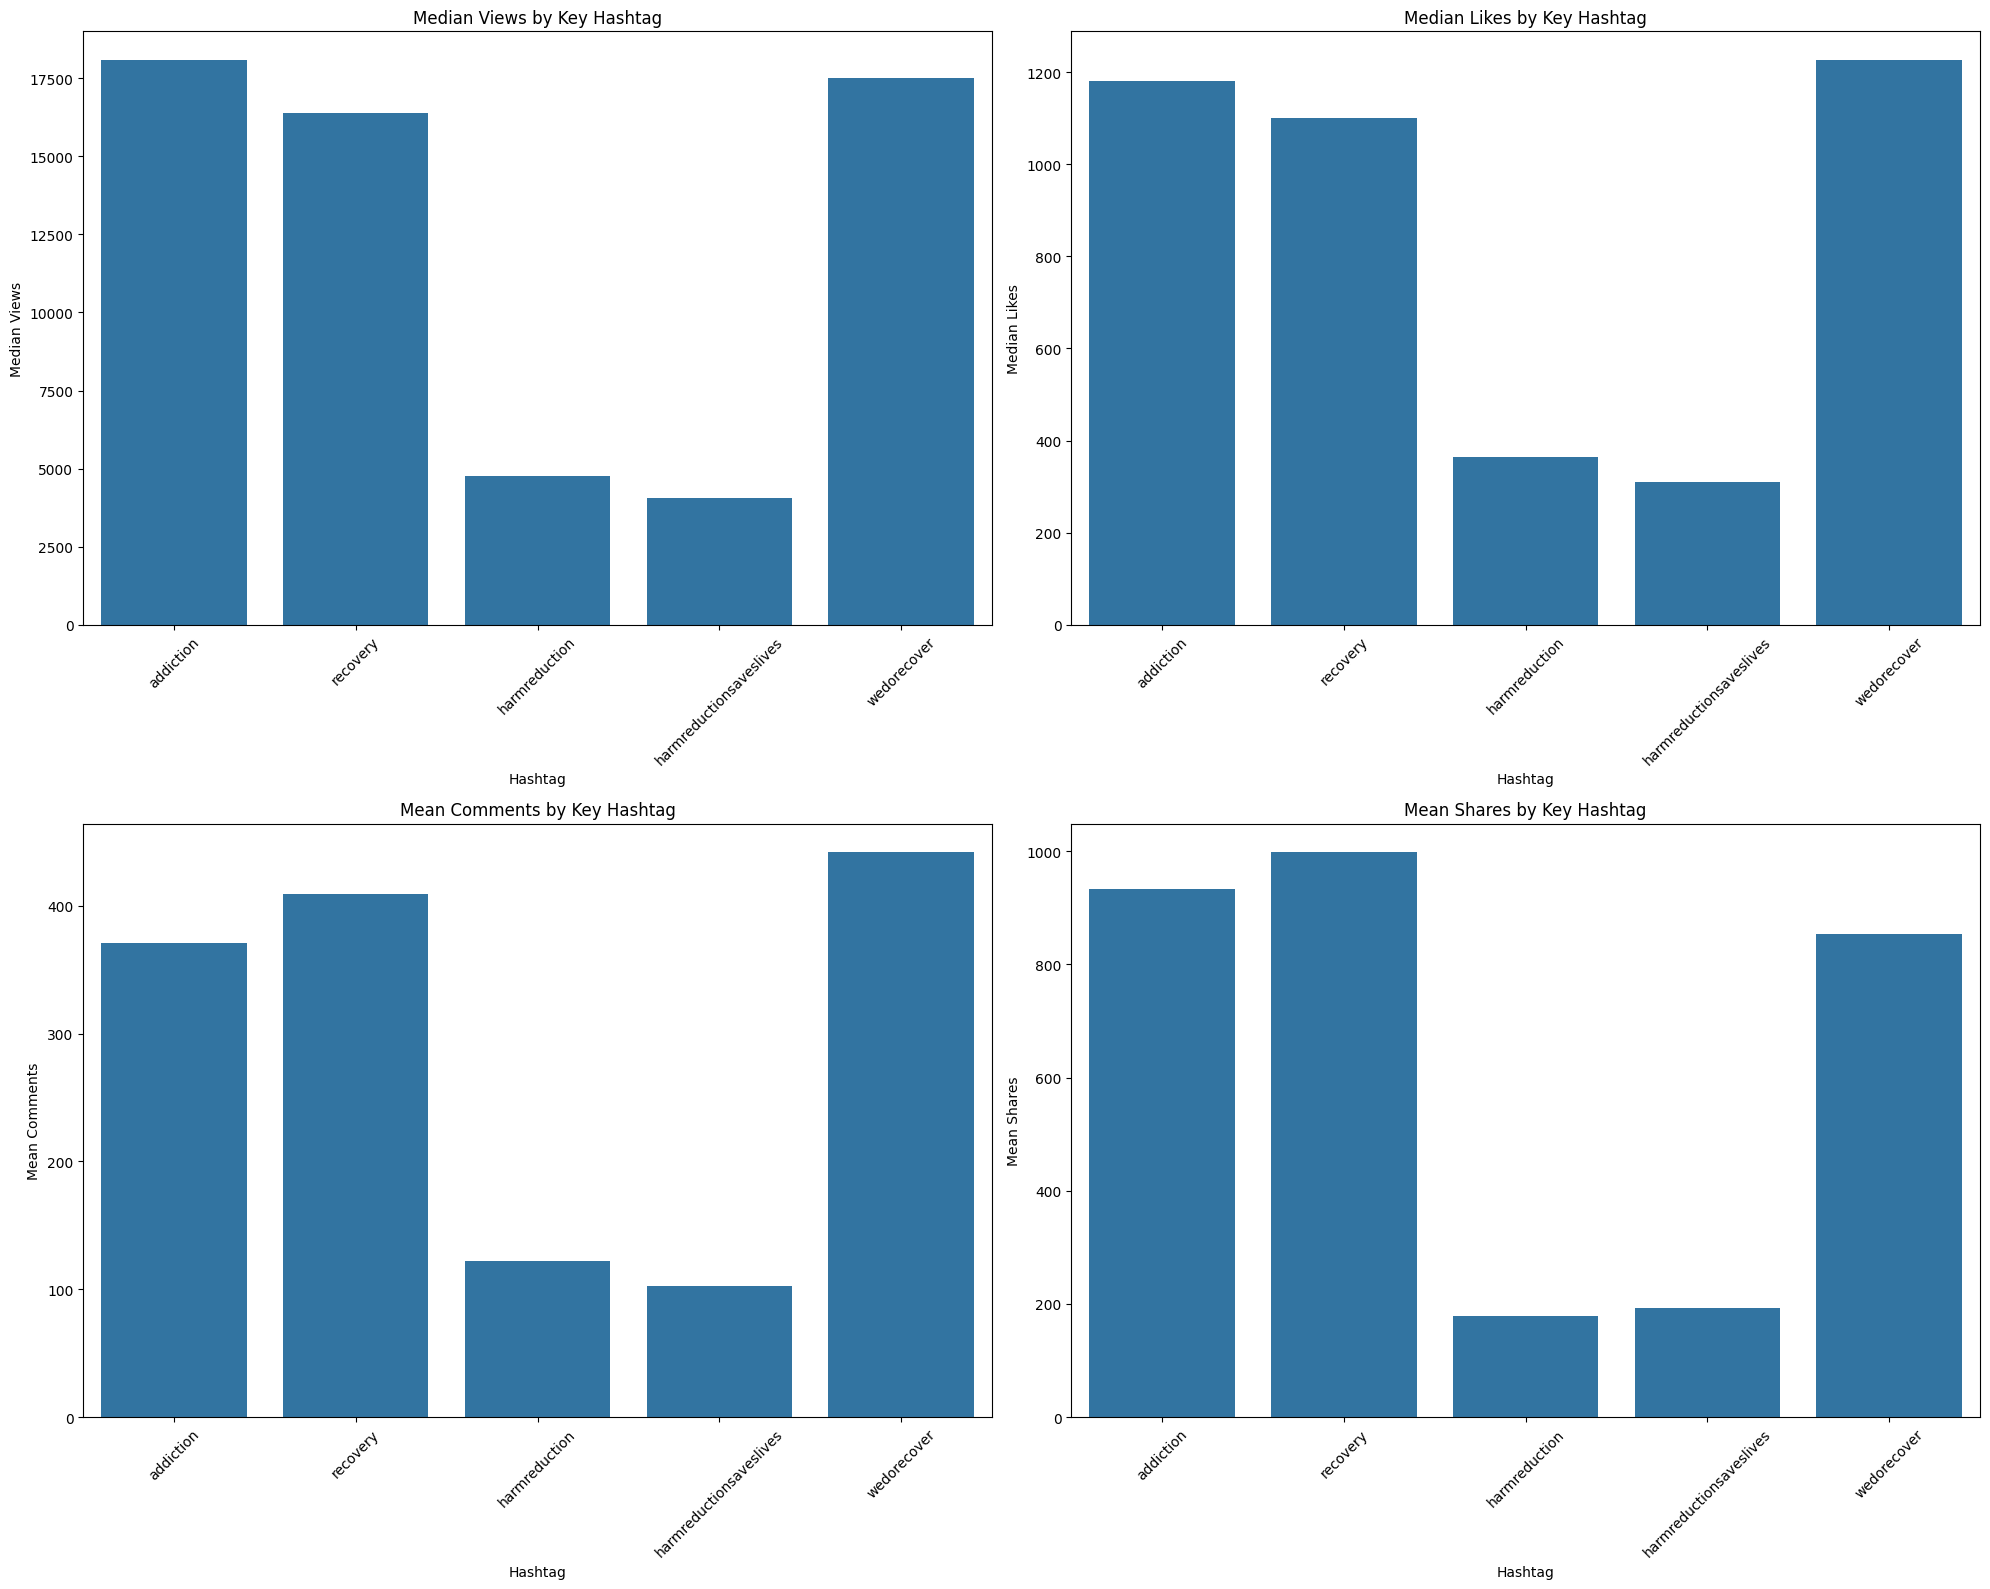

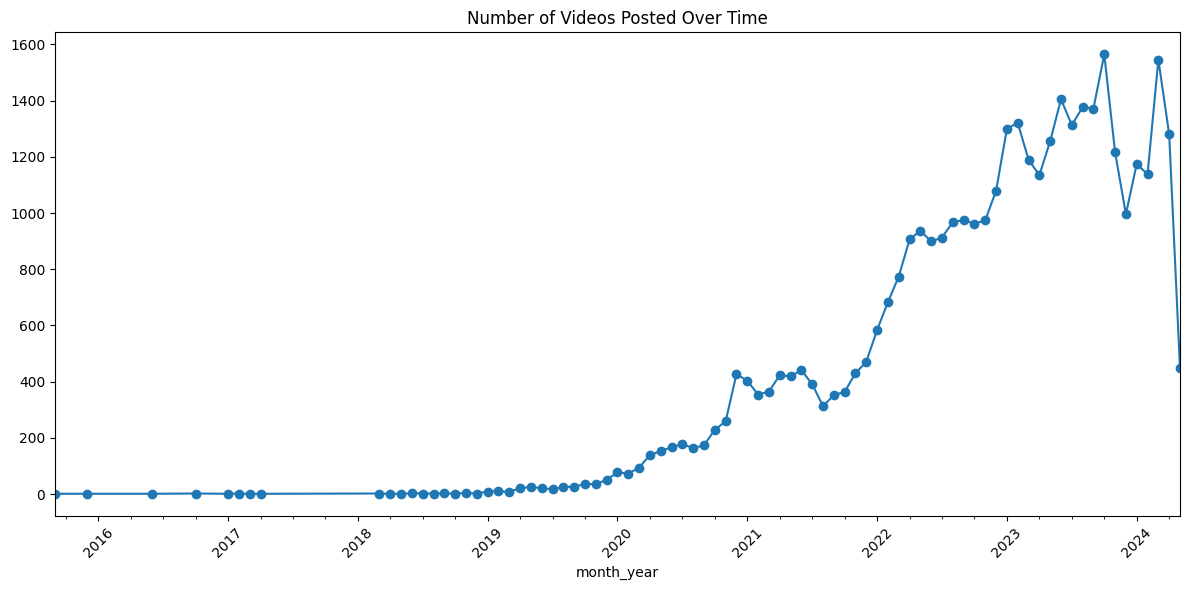

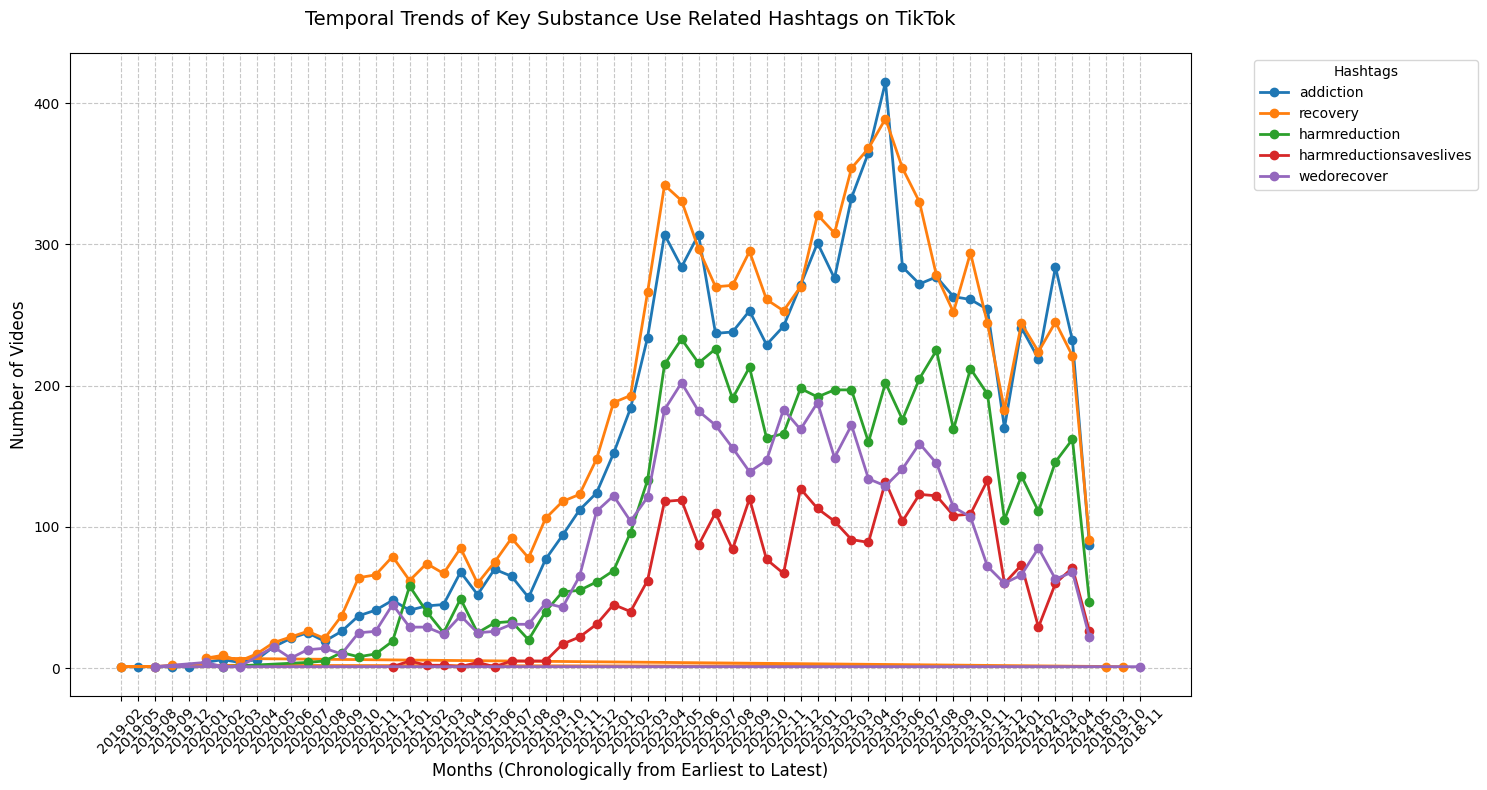


Key Hashtag Statistics:
                         video_count     mean_plays  median_plays  \
addiction                     8683.0  285267.438097       18100.0   
recovery                      9578.0  297446.810921       16400.0   
harmreduction                 5584.0   66057.822170        4772.5   
harmreductionsaveslives       2732.0   73306.862372        4050.5   
wedorecover                   4528.0  287369.508392       17500.0   

                           mean_likes  median_likes  mean_shares  \
addiction                25331.577335        1180.0   933.039963   
recovery                 26060.295364        1101.0   998.250574   
harmreduction             6127.724570         363.5   178.450036   
harmreductionsaveslives   6876.386896         310.0   193.274890   
wedorecover              24175.760159        1227.5   854.005300   

                         mean_comments  
addiction                   370.767016  
recovery                    409.092817  
harmreduction               

In [17]:
results = main_analysis(dat)

In [13]:
print(dat['datetime'].describe())
print(dat['month_year'].value_counts().sort_index())

count                            38863
mean     2022-11-25 15:06:01.132105472
min                2015-09-22 16:58:03
25%                2022-04-16 23:21:37
50%                2023-02-07 00:08:24
75%                2023-09-23 02:56:38
max                2024-05-13 20:58:38
Name: datetime, dtype: object
month_year
2015-09       1
2015-12       1
2016-06       1
2016-10       2
2017-01       1
           ... 
2024-01    1175
2024-02    1138
2024-03    1546
2024-04    1280
2024-05     447
Freq: M, Name: count, Length: 83, dtype: int64
